In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('updatedcreditcard.csv')
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,...,merch_lat,merch_long,is_fraud,age,year,month,hour,day_of_week,age_group,distance_km
0,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,...,36.011293,-82.048315,0,30,2019,1,0,1,25-34,78.597568
1,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,...,49.159047,-118.186462,0,40,2019,1,0,1,35-44,30.212176
2,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,...,43.150704,-112.154481,0,56,2019,1,0,1,55-64,108.206083
3,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,...,47.034331,-112.561071,0,51,2019,1,0,1,45-54,95.673231
4,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,...,38.674999,-78.632459,0,32,2019,1,0,1,25-34,77.556744


Initial shape of X: (1048575, 24)
Initial shape of y: (1048575,)
Class distribution:
 is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64 %

=== FINAL SPLITS ===
Train shape: (838860, 24) (838860,)
Validation shape: (104857, 24) (104857,)
Test shape: (104858, 24) (104858,)

Train class distribution:
 is_fraud
0    99.427199
1     0.572801
Name: proportion, dtype: float64 %
Val class distribution:
 is_fraud
0    99.427792
1     0.572208
Name: proportion, dtype: float64 %
Test class distribution:
 is_fraud
0    99.426844
1     0.573156
Name: proportion, dtype: float64 %

[INFO] Shape of X_train_enc BEFORE SMOTE: (838860, 13)
Class distribution in y_train_temp BEFORE SMOTE: [834055   4805]

[INFO] Shape of X_train_enc AFTER SMOTE: (1668110, 13)
Class distribution in y_train_sm AFTER SMOTE: [834055 834055]

[DEBUG] Final Encoded Feature List (Train/Val/Test share):
['amt', 'distance_km', 'age', 'city_pop', 'year', 'month', 'hour', 'day_of_week', 'gender_M', 'city_te', '

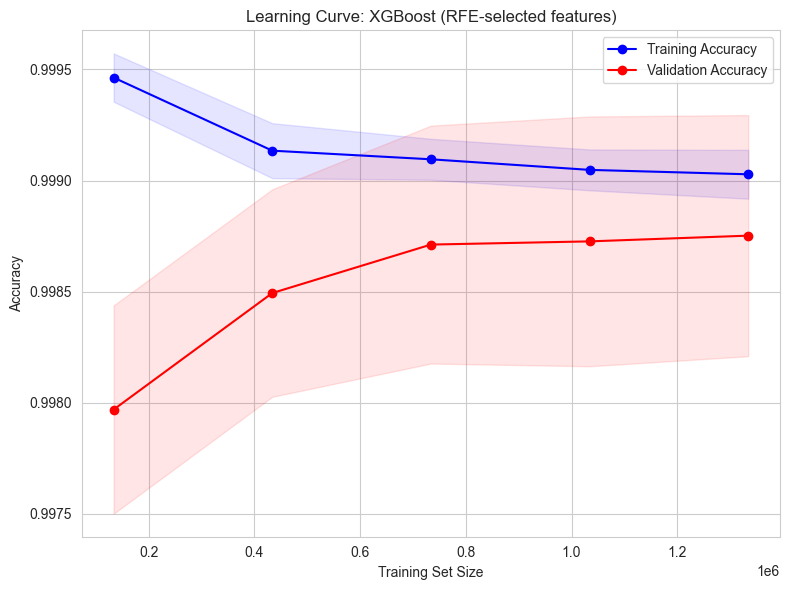

In [ ]:
# -----------------------------------------------------------
# 1) IMPORTS & SETUP
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn / ML
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost (CPU-based)
import xgboost as xgb

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Advanced encoding for high-cardinality or single-col cat
from category_encoders import TargetEncoder

# For synthetic sampling (SMOTE)
from imblearn.over_sampling import SMOTE

# Optional progress bar
from tqdm import tqdm

sns.set_style("whitegrid")

# -----------------------------------------------------------
# 2) CREATE A COPY OF DF -> comp_df AND SPLIT INTO TRAIN/VAL/TEST
# -----------------------------------------------------------
"""
We assume your original DataFrame is named 'df' and has columns:
   'category','amt','gender','city','state','city_pop','job',
   'is_fraud','age','year','month','hour','day_of_week','distance_km',
   etc. (adjust as needed).

We will:
   1) Make a copy: comp_df = df.copy()
   2) Use comp_df in all subsequent transformations and modeling.
"""

# 2.1) Copy the original DataFrame
comp_df = df.copy()

# 2.2) Define the columns we actually need
useful_cols = [
    "category", "amt", "gender", "city", "state", "city_pop", "job",
    "is_fraud", "age", "year", "month", "hour", "day_of_week", 
    "distance_km"
]

# 2.3) Clean: drop rows with missing data (if any)
comp_df.dropna(subset=useful_cols, inplace=True)

# 2.4) X / y
X = comp_df.drop(columns=["is_fraud"])
y = comp_df["is_fraud"].astype(int)

print("Initial shape of X:", X.shape)
print("Initial shape of y:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True)*100, "%")

# Split: 80% Train / 20% Temp
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# From the 20% Temp, split 50/50 => 10% Validation, 10% Test (of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("\n=== FINAL SPLITS ===")
print("Train shape:", X_train_temp.shape, y_train_temp.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nTrain class distribution:\n", y_train_temp.value_counts(normalize=True)*100, "%")
print("Val class distribution:\n", y_val.value_counts(normalize=True)*100, "%")
print("Test class distribution:\n", y_test.value_counts(normalize=True)*100, "%")

# -----------------------------------------------------------
# 3) COLUMN GROUPS FOR ENCODING
# -----------------------------------------------------------
numeric_features = [
    "amt", "distance_km", "age", "city_pop", 
    "year", "month", "hour", "day_of_week"
]
cat_small = ["gender"]                         # one-hot
cat_high  = ["city","state","job","category"]  # target-encode

# -----------------------------------------------------------
# 4) COLUMNTRANSFORMER (SCALING + ENCODING)
# -----------------------------------------------------------
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

target_encoder = Pipeline([
    ("target_enc", TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ohe", ohe_transformer, cat_small),
        ("te",  target_encoder,  cat_high),
    ],
    remainder="drop"
)

# -----------------------------------------------------------
# 5) FIT PREPROCESSOR & APPLY SMOTE (TRAIN ONLY)
# -----------------------------------------------------------
X_train_enc = preprocessor.fit_transform(X_train_temp, y_train_temp)
print("\n[INFO] Shape of X_train_enc BEFORE SMOTE:", X_train_enc.shape)
print("Class distribution in y_train_temp BEFORE SMOTE:", np.bincount(y_train_temp))

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train_temp)

print("\n[INFO] Shape of X_train_enc AFTER SMOTE:", X_train_sm.shape)
print("Class distribution in y_train_sm AFTER SMOTE:", np.bincount(y_train_sm))

# Encode validation & test sets (do NOT refit)
X_val_enc  = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

# Build final feature name list
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(cat_small)
te_cols = [f"{col}_te" for col in cat_high]
final_feature_names = numeric_features + list(ohe_feature_names) + te_cols

print("\n[DEBUG] Final Encoded Feature List (Train/Val/Test share):")
print(final_feature_names)

# ===========================================================
# PART A: XGBOOST 
# ===========================================================
print("\n==================== XGBOOST PIPELINE ====================\n")

# -----------------------------------------------------------
# A.1) RFE USING XGBoost ON TRAIN
# -----------------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

xgb_rfe = RFE(
    estimator=xgb_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (XGBoost) on TRAIN ONLY... (this may take a while)")
xgb_rfe.fit(X_train_sm, y_train_sm)

xgb_support_mask = xgb_rfe.support_
xgb_ranking = xgb_rfe.ranking_

print("\n[DEBUG] XGBoost RFE Feature Ranking Results:")
for i, feat_name in enumerate(final_feature_names):
    print(f"{i}: {feat_name} | Support={xgb_support_mask[i]}, Rank={xgb_ranking[i]}")

xgb_selected_features = [f for f, s in zip(final_feature_names, xgb_support_mask) if s]
print("\n=== SELECTED FEATURES by XGBoost RFE ===")
for feat in xgb_selected_features:
    print("   -", feat)

X_train_sel_xgb = xgb_rfe.transform(X_train_sm)
X_val_sel_xgb   = xgb_rfe.transform(X_val_enc)
X_test_sel_xgb  = xgb_rfe.transform(X_test_enc)

# -----------------------------------------------------------
# A.2) TRAIN FINAL XGBOOST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_xgb = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

print("\n[DEBUG] Training final XGBoost on selected features (TRAIN ONLY)...")
final_xgb.fit(X_train_sel_xgb, y_train_sm)

# -----------------------------------------------------------
# A.3) EVALUATE ON TRAIN SET FIRST (OVERFITTING CHECK)
# -----------------------------------------------------------
xgb_train_pred = final_xgb.predict(X_train_sel_xgb)
xgb_train_acc  = accuracy_score(y_train_sm, xgb_train_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON TRAIN SET (WITH SMOTE) ===")
print("Accuracy (Train):", xgb_train_acc)
print("Classification Report (Train):\n", classification_report(y_train_sm, xgb_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, xgb_train_pred))

# -----------------------------------------------------------
# A.4) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------
xgb_val_pred = final_xgb.predict(X_val_sel_xgb)
xgb_val_acc = accuracy_score(y_val, xgb_val_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", xgb_val_acc)
print("Classification Report (Val):\n", classification_report(y_val, xgb_val_pred))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, xgb_val_pred))

# Decide if we want to proceed to the test set:
XGB_VAL_THRESHOLD = 0.99  # Example threshold. Adjust as needed.

if xgb_val_acc < XGB_VAL_THRESHOLD:
    print(f"\n[WARNING] [XGBoost] Validation Accuracy {xgb_val_acc:.4f} < {XGB_VAL_THRESHOLD}.")
    print("We are NOT satisfied. You may want to tweak hyperparameters, features, etc.")
    print("Skipping test evaluation for XGBoost.\n")
else:
    # -----------------------------------------------------------
    # A.5) EVALUATE ON TEST SET IF VALIDATION IS GOOD
    # -----------------------------------------------------------
    xgb_test_pred = final_xgb.predict(X_test_sel_xgb)
    xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
    print("\n=== [XGBoost] MODEL PERFORMANCE ON TEST SET ===")
    print("Accuracy (Test):", xgb_test_acc)
    print("Classification Report (Test):\n", classification_report(y_test, xgb_test_pred))
    print("Confusion Matrix (Test):\n", confusion_matrix(y_test, xgb_test_pred))

# -----------------------------------------------------------
# A.6) OPTIONAL: PLOT LEARNING CURVE FOR XGBOOST
# -----------------------------------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    final_xgb,
    X_train_sel_xgb,
    y_train_sm,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_means = np.mean(train_scores, axis=1)
train_stds  = np.std(train_scores, axis=1)
val_means   = np.mean(val_scores, axis=1)
val_stds    = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_means, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_means, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds,
                 alpha=0.1, color='red')

plt.title('Learning Curve: XGBoost (RFE-selected features)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
# -----------------------------------------------------------
# 1) IMPORTS & SETUP
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn / ML
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost (CPU-based)
import xgboost as xgb

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Advanced encoding for high-cardinality or single-col cat
from category_encoders import TargetEncoder

# For synthetic sampling (SMOTE)
from imblearn.over_sampling import SMOTE

# Optional progress bar
from tqdm import tqdm

sns.set_style("whitegrid")

# -----------------------------------------------------------
# 2) CREATE A COPY OF DF -> comp_df AND SPLIT INTO TRAIN/VAL/TEST
# -----------------------------------------------------------
"""
We assume your original DataFrame is named 'df' and has columns:
   'category','amt','gender','city','state','city_pop','job',
   'is_fraud','age','year','month','hour','day_of_week','distance_km',
   etc. (adjust as needed).

We will:
   1) Make a copy: comp_df = df.copy()
   2) Use comp_df in all subsequent transformations and modeling.
"""

# 2.1) Copy the original DataFrame
comp_df = df.copy()

# 2.2) Define the columns we actually need
useful_cols = [
    "category", "amt", "gender", "city", "state", "city_pop", "job",
    "is_fraud", "age", "year", "month", "hour", "day_of_week", 
    "distance_km"
]

# 2.3) Clean: drop rows with missing data (if any)
comp_df.dropna(subset=useful_cols, inplace=True)

# 2.4) X / y
X = comp_df.drop(columns=["is_fraud"])
y = comp_df["is_fraud"].astype(int)

print("Initial shape of X:", X.shape)
print("Initial shape of y:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True)*100, "%")

# Split: 80% Train / 20% Temp
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# From the 20% Temp, split 50/50 => 10% Validation, 10% Test (of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("\n=== FINAL SPLITS ===")
print("Train shape:", X_train_temp.shape, y_train_temp.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nTrain class distribution:\n", y_train_temp.value_counts(normalize=True)*100, "%")
print("Val class distribution:\n", y_val.value_counts(normalize=True)*100, "%")
print("Test class distribution:\n", y_test.value_counts(normalize=True)*100, "%")

# -----------------------------------------------------------
# 3) COLUMN GROUPS FOR ENCODING
# -----------------------------------------------------------
numeric_features = [
    "amt", "distance_km", "age", "city_pop", 
    "year", "month", "hour", "day_of_week"
]
cat_small = ["gender"]                         # one-hot
cat_high  = ["city","state","job","category"]  # target-encode

# -----------------------------------------------------------
# 4) COLUMNTRANSFORMER (SCALING + ENCODING)
# -----------------------------------------------------------
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

target_encoder = Pipeline([
    ("target_enc", TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ohe", ohe_transformer, cat_small),
        ("te",  target_encoder,  cat_high),
    ],
    remainder="drop"
)

# -----------------------------------------------------------
# 5) FIT PREPROCESSOR & APPLY SMOTE (TRAIN ONLY)
# -----------------------------------------------------------
X_train_enc = preprocessor.fit_transform(X_train_temp, y_train_temp)
print("\n[INFO] Shape of X_train_enc BEFORE SMOTE:", X_train_enc.shape)
print("Class distribution in y_train_temp BEFORE SMOTE:", np.bincount(y_train_temp))

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train_temp)

print("\n[INFO] Shape of X_train_enc AFTER SMOTE:", X_train_sm.shape)
print("Class distribution in y_train_sm AFTER SMOTE:", np.bincount(y_train_sm))

# Encode validation & test sets (do NOT refit)
X_val_enc  = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

# Build final feature name list
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(cat_small)
te_cols = [f"{col}_te" for col in cat_high]
final_feature_names = numeric_features + list(ohe_feature_names) + te_cols

print("\n[DEBUG] Final Encoded Feature List (Train/Val/Test share):")
print(final_feature_names)

# ===========================================================
# PART A: XGBOOST 
# ===========================================================
print("\n==================== XGBOOST PIPELINE ====================\n")

# -----------------------------------------------------------
# A.1) RFE USING XGBoost ON TRAIN
# -----------------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

xgb_rfe = RFE(
    estimator=xgb_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (XGBoost) on TRAIN ONLY... (this may take a while)")
xgb_rfe.fit(X_train_sm, y_train_sm)

xgb_support_mask = xgb_rfe.support_
xgb_ranking = xgb_rfe.ranking_

print("\n[DEBUG] XGBoost RFE Feature Ranking Results:")
for i, feat_name in enumerate(final_feature_names):
    print(f"{i}: {feat_name} | Support={xgb_support_mask[i]}, Rank={xgb_ranking[i]}")

xgb_selected_features = [f for f, s in zip(final_feature_names, xgb_support_mask) if s]
print("\n=== SELECTED FEATURES by XGBoost RFE ===")
for feat in xgb_selected_features:
    print("   -", feat)

X_train_sel_xgb = xgb_rfe.transform(X_train_sm)
X_val_sel_xgb   = xgb_rfe.transform(X_val_enc)
X_test_sel_xgb  = xgb_rfe.transform(X_test_enc)


Initial shape of X: (1048575, 24)
Initial shape of y: (1048575,)
Class distribution:
 is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64 %

=== FINAL SPLITS ===
Train shape: (838860, 24) (838860,)
Validation shape: (104857, 24) (104857,)
Test shape: (104858, 24) (104858,)

Train class distribution:
 is_fraud
0    99.427199
1     0.572801
Name: proportion, dtype: float64 %
Val class distribution:
 is_fraud
0    99.427792
1     0.572208
Name: proportion, dtype: float64 %
Test class distribution:
 is_fraud
0    99.426844
1     0.573156
Name: proportion, dtype: float64 %

[INFO] Shape of X_train_enc BEFORE SMOTE: (838860, 13)
Class distribution in y_train_temp BEFORE SMOTE: [834055   4805]

[INFO] Shape of X_train_enc AFTER SMOTE: (1668110, 13)
Class distribution in y_train_sm AFTER SMOTE: [834055 834055]

[DEBUG] Final Encoded Feature List (Train/Val/Test share):
['amt', 'distance_km', 'age', 'city_pop', 'year', 'month', 'hour', 'day_of_week', 'gender_M', 'city_te', '

In [ ]:

# -----------------------------------------------------------
# A.2) TRAIN FINAL XGBOOST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_xgb = xgb.XGBClassifier(
    n_estimators=500,          # Increase the number of trees
    learning_rate=0.15,        # Smaller learning rate
    max_depth=8,               # Moderate tree depth
    min_child_weight=5,        # Prevent overfitting
    subsample=0.8,             # Use 80% of data for each tree
    colsample_bytree=0.8,      # Use 80% of features for each tree
    gamma=1,                   # Add regularization
    scale_pos_weight=173,      # Address class imbalance
    random_state=42,
    verbosity=1,
    tree_method='hist'         # Optimized tree growth
)


print("\n[DEBUG] Training final XGBoost on selected features (TRAIN ONLY)...")
final_xgb.fit(X_train_sel_xgb, y_train_sm)


# -----------------------------------------------------------
# A.3) EVALUATE ON TRAIN SET FIRST (OVERFITTING CHECK)
# -----------------------------------------------------------
xgb_train_pred = final_xgb.predict(X_train_sel_xgb)
xgb_train_acc  = accuracy_score(y_train_sm, xgb_train_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON TRAIN SET (WITH SMOTE) ===")
print("Accuracy (Train):", xgb_train_acc)
print("Classification Report (Train):\n", classification_report(y_train_sm, xgb_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, xgb_train_pred))

# -----------------------------------------------------------
# A.4) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------
xgb_val_pred = final_xgb.predict(X_val_sel_xgb)
xgb_val_acc = accuracy_score(y_val, xgb_val_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", xgb_val_acc)
print("Classification Report (Val):\n", classification_report(y_val, xgb_val_pred))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, xgb_val_pred))

# Decide if we want to proceed to the test set:
XGB_VAL_THRESHOLD = 0.99  # Example threshold. Adjust as needed.

if xgb_val_acc < XGB_VAL_THRESHOLD:
    print(f"\n[WARNING] [XGBoost] Validation Accuracy {xgb_val_acc:.4f} < {XGB_VAL_THRESHOLD}.")
    print("We are NOT satisfied. You may want to tweak hyperparameters, features, etc.")
    print("Skipping test evaluation for XGBoost.\n")
else:
    # -----------------------------------------------------------
    # A.5) EVALUATE ON TEST SET IF VALIDATION IS GOOD
    # -----------------------------------------------------------
    xgb_test_pred = final_xgb.predict(X_test_sel_xgb)
    xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
    print("\n=== [XGBoost] MODEL PERFORMANCE ON TEST SET ===")
    print("Accuracy (Test):", xgb_test_acc)
    print("Classification Report (Test):\n", classification_report(y_test, xgb_test_pred))
    print("Confusion Matrix (Test):\n", confusion_matrix(y_test, xgb_test_pred))

# -----------------------------------------------------------
# A.6) OPTIONAL: PLOT LEARNING CURVE FOR XGBOOST
# -----------------------------------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    final_xgb,
    X_train_sel_xgb,
    y_train_sm,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_means = np.mean(train_scores, axis=1)
train_stds  = np.std(train_scores, axis=1)
val_means   = np.mean(val_scores, axis=1)
val_stds    = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_means, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_means, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds,
                 alpha=0.1, color='red')

plt.title('Learning Curve: XGBoost (RFE-selected features)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
import math

# -----------------------------------------------------------
# GRID SEARCH FOR HYPERPARAMETER TUNING WITH PROGRESS BAR
# -----------------------------------------------------------
print("\n[DEBUG] Starting Grid Search for XGBoost...")

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [ 8, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.8, 1.0],
    
}


# Calculate the total number of parameter combinations
total_combinations = math.prod(len(v) for v in param_grid.values())
cv_folds = 3  # Number of cross-validation folds
total_iterations = total_combinations * cv_folds

# Initialize the tqdm progress bar
progress_bar = tqdm(total=total_iterations, desc="GridSearchCV Progress", unit="fit")

# Use tqdm_joblib to integrate tqdm with joblib's Parallel
with tqdm_joblib(progress_bar):
    # Initialize the XGBoost classifier
    xgb_clf_tune = xgb.XGBClassifier(
        random_state=42,
        tree_method='hist',
        verbosity=1,
        scale_pos_weight=173  # Maintain class imbalance adjustment
    )
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_clf_tune,
        param_grid=param_grid,
        scoring='accuracy',   # Change to 'f1', 'roc_auc', etc., if needed
        cv=cv_folds,          # 3-fold cross-validation
        verbose=0,            # Set to 0 to prevent GridSearchCV from printing its own messages
        n_jobs=-1             # Utilize all CPU cores
    )
    
    # Perform the grid search on the selected training set
    grid_search.fit(X_train_sel_xgb, y_train_sm)

# Close the progress bar after completion
progress_bar.close()

# Best parameters and score
print("\n[INFO] Best Parameters from Grid Search:\n", grid_search.best_params_)
print("\n[INFO] Best Cross-Validation Accuracy:\n", grid_search.best_score_)

# -----------------------------------------------------------
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# -----------------------------------------------------------
print("\n[DEBUG] Training final model with best parameters...")
best_params = grid_search.best_params_

final_xgb_optimized = xgb.XGBClassifier(
    **best_params,        # Use the best parameters from Grid Search
    random_state=42,
    tree_method='hist',
    verbosity=1,
    scale_pos_weight=173  # Maintain class imbalance adjustment
)

# Train on the full training data
final_xgb_optimized.fit(X_train_sel_xgb, y_train_sm)

# -----------------------------------------------------------
# FINAL EVALUATION ON VALIDATION AND TEST SETS
# -----------------------------------------------------------
# Validation Set
xgb_val_pred_opt = final_xgb_optimized.predict(X_val_sel_xgb)
xgb_val_acc_opt = accuracy_score(y_val, xgb_val_pred_opt)
print("\n=== [Optimized XGBoost] MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", xgb_val_acc_opt)
print("Classification Report (Val):\n", classification_report(y_val, xgb_val_pred_opt))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, xgb_val_pred_opt))

# Test Set (if validation results are satisfactory)
xgb_test_pred_opt = final_xgb_optimized.predict(X_test_sel_xgb)
xgb_test_acc_opt = accuracy_score(y_test, xgb_test_pred_opt)
print("\n=== [Optimized XGBoost] MODEL PERFORMANCE ON TEST SET ===")
print("Accuracy (Test):", xgb_test_acc_opt)
print("Classification Report (Test):\n", classification_report(y_test, xgb_test_pred_opt))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, xgb_test_pred_opt))



[DEBUG] Starting Grid Search for XGBoost...


GridSearchCV Progress:   0%|          | 0/72 [00:00<?, ?fit/s]

  0%|          | 0/72 [00:00<?, ?it/s]


[INFO] Best Parameters from Grid Search:
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}

[INFO] Best Cross-Validation Accuracy:
 0.9994077129188135

[DEBUG] Training final model with best parameters...

=== [Optimized XGBoost] MODEL PERFORMANCE ON VALIDATION SET ===
Accuracy (Val): 0.9986171643285617
Classification Report (Val):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    104257
           1       0.86      0.90      0.88       600

    accuracy                           1.00    104857
   macro avg       0.93      0.95      0.94    104857
weighted avg       1.00      1.00      1.00    104857

Confusion Matrix (Val):
 [[104170     87]
 [    58    542]]

=== [Optimized XGBoost] MODEL PERFORMANCE ON TEST SET ===
Accuracy (Test): 0.9987888382383795
Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.